In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit,train_epoch
import numpy as np


from datasets import TripletSampling, BatchPairSampling
from networks import EmbeddingNet, SiameseNet
from losses import TripletLoss, HardNegativesBatchLoss

cuda = torch.cuda.is_available()

### Load dataset and construct fake grouping

In [15]:

data_set = pd.read_csv('./data/Diffusion_data.csv')

drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
data_set = data_set.drop(drop_columns, axis = 1)

data_set_shuffled = data_set.sample(frac=1).reset_index(drop=True)

data_set_shuffled = torch.tensor(data_set_shuffled.values)

# fake labels for pos/neg
labels = [1]* int(0.5 * data_set_shuffled.shape[0]) + [0]*int( 0.5 * data_set_shuffled.shape[0] ) 

In [16]:
data_set_shuffled.shape

torch.Size([408, 24])

### Test training

In [17]:
margin = 1
distance = None
lr = 1e-3
hidden_size = 100
embedding_size = 20

input_size = data_set_shuffled.shape[1]

loss_fn = HardNegativesBatchLoss( margin = margin, distance = distance)



net = EmbeddingNet(input_size, hidden_size, embedding_size)

siamese_net = SiameseNet(  embedding_net = net )


model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40

datasampler = BatchPairSampling( dataset = data_set_shuffled , labels=labels)
batch_size = 5
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [18]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)


Train: [0/408 (0%)]	Loss: 1.017995
Train: [50/408 (12%)]	Loss: 1.215185
Train: [100/408 (24%)]	Loss: 1.034351
Train: [150/408 (37%)]	Loss: 0.559773
Train: [200/408 (49%)]	Loss: 0.976321
Train: [250/408 (61%)]	Loss: 0.690936
Train: [300/408 (73%)]	Loss: 0.463462
Train: [350/408 (85%)]	Loss: 0.927484
Train: [400/408 (98%)]	Loss: 0.055444
Epoch: 1/40. Train set: Average loss: 0.7636
Train: [0/408 (0%)]	Loss: 0.418724
Train: [50/408 (12%)]	Loss: 0.991407
Train: [100/408 (24%)]	Loss: 0.531135
Train: [150/408 (37%)]	Loss: 0.763334
Train: [200/408 (49%)]	Loss: 0.816202
Train: [250/408 (61%)]	Loss: 0.592889
Train: [300/408 (73%)]	Loss: 0.500051
Train: [350/408 (85%)]	Loss: 1.412046
Train: [400/408 (98%)]	Loss: 0.627668
Epoch: 2/40. Train set: Average loss: 0.7654
Train: [0/408 (0%)]	Loss: 0.000000
Train: [50/408 (12%)]	Loss: 0.520153
Train: [100/408 (24%)]	Loss: 0.524967
Train: [150/408 (37%)]	Loss: 0.643346
Train: [200/408 (49%)]	Loss: 0.919373
Train: [250/408 (61%)]	Loss: 0.488998
Train: [30

Train: [100/408 (24%)]	Loss: 0.655724
Train: [150/408 (37%)]	Loss: 0.472292
Train: [200/408 (49%)]	Loss: 0.782963
Train: [250/408 (61%)]	Loss: 0.651411
Train: [300/408 (73%)]	Loss: 0.426213
Train: [350/408 (85%)]	Loss: 0.489796
Train: [400/408 (98%)]	Loss: 1.088066
Epoch: 23/40. Train set: Average loss: 0.6379
Train: [0/408 (0%)]	Loss: 0.929504
Train: [50/408 (12%)]	Loss: 0.437630
Train: [100/408 (24%)]	Loss: 0.766504
Train: [150/408 (37%)]	Loss: 0.752049
Train: [200/408 (49%)]	Loss: 0.291407
Train: [250/408 (61%)]	Loss: 0.538829
Train: [300/408 (73%)]	Loss: 0.646536
Train: [350/408 (85%)]	Loss: 0.272200
Train: [400/408 (98%)]	Loss: 0.713711
Epoch: 24/40. Train set: Average loss: 0.5502
Train: [0/408 (0%)]	Loss: 0.000000
Train: [50/408 (12%)]	Loss: 0.121240
Train: [100/408 (24%)]	Loss: 0.116858
Train: [150/408 (37%)]	Loss: 0.488367
Train: [200/408 (49%)]	Loss: 0.701101
Train: [250/408 (61%)]	Loss: 0.613983
Train: [300/408 (73%)]	Loss: 0.949275
Train: [350/408 (85%)]	Loss: 0.425689
Trai

In [19]:
def extract_embeddings(dataset, labels, model):
    with torch.no_grad():
        model.eval()
        embeddings = []

        for data in dataset:

            embeddings.append( 
                np.array( 
                    model.get_embedding(data).detach().numpy() ) )

    return np.array(embeddings), labels

In [20]:
embs,labels = extract_embeddings(data_set_shuffled , labels, model)
embs.shape

(408, 20)

In [21]:

from sklearn.manifold import TSNE
# embedded_2 = TSNE(n_components=2, learning_rate='auto',
#      init='random').fit_transform(embs)
tsne = TSNE(n_components=2, perplexity = 5, learning_rate='auto',init='random')
mds = sklearn.manifold.MDS(n_components=2,metric=True, 
                                  n_init=4, 
                                  max_iter=500,
                                  verbose=0, eps=0.001, n_jobs=None, random_state= 1024, dissimilarity='euclidean')


In [22]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    targets = np.array(targets)
    colors = ['r', 'b']
    shapes = ['*', '^']
    for cls in set(targets):
        mask = targets == cls
        cls_emb = embeddings[mask]
        plt.scatter(cls_emb[:,0], cls_emb[:,1], alpha=0.5, marker = shapes[cls],c = colors[cls])

    plt.legend(set(targets))

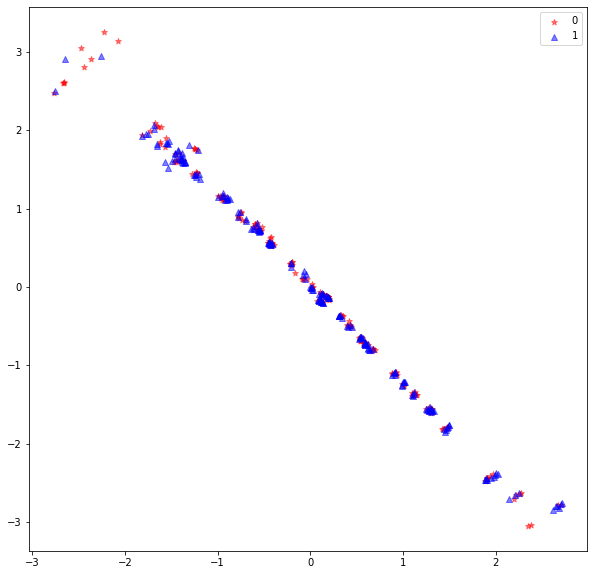

In [23]:
embedded_2_mds = mds.fit_transform(embs)
plot_embeddings(embedded_2_mds, labels)

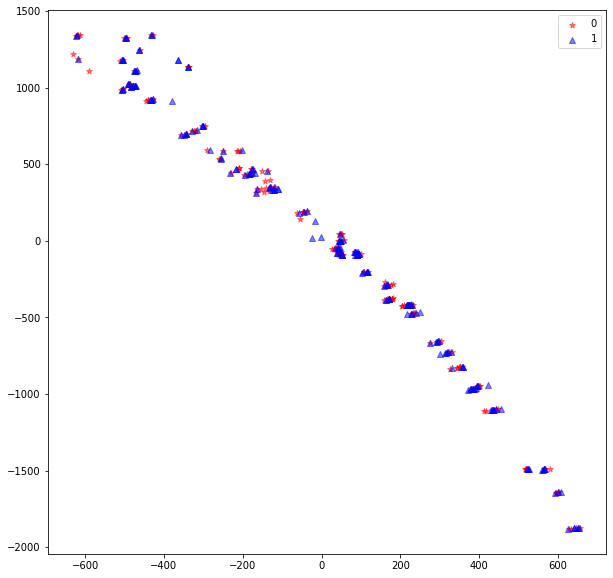

In [24]:
embedded_2_origin_mds = mds.fit_transform(data_set_shuffled)
plot_embeddings(embedded_2_origin_mds, labels)